# Week 3: Day 4 PM // Practical Statistics: Inferential

Import required Python packages.

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

## Resampling

Resampling in statistics means to repeatedly sample values from observed data, with a
general goal of assessing random variability in a statistic.

### Permutation Test

In a permutation procedure, two or more samples are involved, typically the groups
in an A/B or other hypothesis test. Permute means to change the order of a set of values. The first step in a permutation test of a hypothesis is to combine the results from
groups A and B (and, if used, C, D,…). This is the logical embodiment of the null
hypothesis that the treatments to which the groups were exposed do not differ. We
then test that hypothesis by randomly drawing groups from this combined set and
seeing how much they differ from one another. The permutation procedure is as
follows:
1. Combine the results from the different groups into a single data set.
2. Shuffle the combined data and then randomly draw (without replacement) a
resample of the same size as group A (clearly it will contain some data from the
other groups).
3. From the remaining data, randomly draw (without replacement) a resample of
the same size as group B.
4. Do the same for groups C, D, and so on. You have now collected one set of
resamples that mirror the sizes of the original samples.
5. Whatever statistic or estimate was calculated for the original samples (e.g., differ‐
ence in group proportions), calculate it now for the resamples, and record; this
constitutes one permutation iteration.
6. Repeat the previous steps R times to yield a permutation distribution of the test
statistic

Another type of permutation is bootstrap permutation test, wgere the draws outlined in steps 2 and 3 of the random
permutation test are made with replacement instead of without replacement. In this
way the resampling procedure models not just the random element in the assignment
of treatment to subject but also the random element in the selection of subjects from
a population. Both procedures are encountered in statistics, and the distinction
between them is somewhat convoluted and not of consequence in the practice of data
science.

On this example, we want to compare average session time between page A to page B.

In [4]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

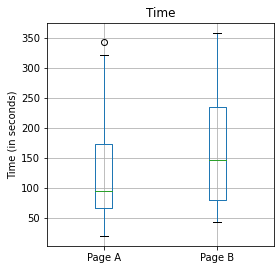

In [5]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [6]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


Page B has session times that are greater than those of page A by 35.67 seconds, on average. The question is whether this difference is within the range of what random chance might produce, i.e., is statistically significant. One way to answer this is to apply a permutation test—combine all the session times together and then repeatedly shuffle and divide them into groups of 21 (recall that nA = 21 for page A) and 15 (nB = 15 for page B).

The key is to **combine** both data into one mix and randomly splitting them back into groups.

In [7]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean(),idx_A,idx_B
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
diff_mean,idx_A,idx_B = perm_fun(session_times.Time, nA, nB)
print(perm_fun(session_times.Time, nA, nB)[0])
print(idx_A)
print(idx_B)

27.2095238095238
{0, 1, 2, 3, 5, 7, 11, 12, 13, 15, 16, 18, 24, 25, 26, 27, 29, 31, 32, 33, 35}
{34, 4, 6, 8, 9, 10, 14, 17, 19, 20, 21, 22, 23, 28, 30}


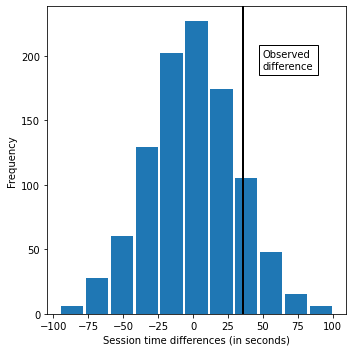

In [9]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB)[0] for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
print(np.mean(np.greater(perm_diffs,(mean_b - mean_a))))

0.121


This suggests that the observed difference in session time between page A and page B
is well within the range of chance variation and thus is not statistically significant.

## Statistical Significance and P-Values

Observed difference: 0.0368%


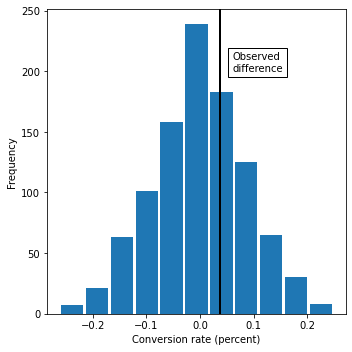

In [12]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588)[0] 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### P-Value
If `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

In [13]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [14]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


## t-Tests

In [15]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


In [16]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


We can use t-Table to determine p-value

![image info](pics/t_table.jpg)

## ANOVA

The one-way analysis of variance (ANOVA) is used to determine whether there are any statistically significant differences between the means of three or more independent (unrelated) groups. ANOVA can be used for comparison between multiple groups

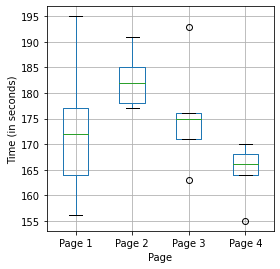

In [17]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [18]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


### Permutation Approach

1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each.
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 1,000) times.

In [19]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
7.000000000000039


Pr(Prob) 0.07933333333333334


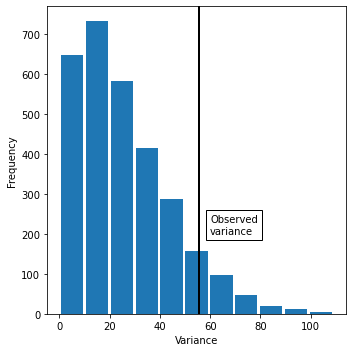

In [20]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### F-Statistic
We can compute an ANOVA table using statsmodel.

In [21]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [22]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


F statistic is based on the ratio of the variance across group means (i.e., the treatment effect) to the variance due to residual error. 

The higher this ratio, the more statistically significant the result. 

If the data follows a normal distribution, then statistical theory dictates that the statistic should have a certain distribution. Based on this, it is possible to compute a p-value

### Two-way anova only available with statsmodels
```
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)
```

## Chi-Square Test

The chi-square test, or Fisher’s exact test, is used when you want to know whether an
effect is for real or might be the product of chance. A chi-square test for independence compares two variables in a contingency table to see if they are related. In a more general sense, it tests to see whether distributions of categorical variables differ from each another.

$ H_{0} $: In the population, the two categorical variables are unrelated

$ H_{a} $: In the population, the two categorical variables are related

### Chi-Square Test: A Resampling Approach

In [45]:
click_rate.head(5)

Headline     Click  Rate
0  Headline A     Click    14
1  Headline A  No-click   986
2  Headline B     Click     8
3  Headline B  No-click   992
4  Headline C     Click    12

In [23]:
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [48]:
clicks

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988

In [49]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

Headline A  Headline B  Headline C
Click                                       
Click      11.333333   11.333333   11.333333
No-click  988.666667  988.666667  988.666667

In [25]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4820


$$ \chi{2} = \Sigma\frac{(O_i-E_i)^2}{E_i} $$

$$ E = \frac{\text{(row_total)(column_total)}}{\text{total_sample_size}} $$

O is observed count for each cell amd E denote the respective expected counts for each cell.

In [50]:
clicks

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988

In [51]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


In [53]:
expected

array([[ 11.33333333,  11.33333333,  11.33333333],
       [988.66666667, 988.66666667, 988.66666667]])

In [56]:
import pandas as pd
import scipy.stats as stats

# To load a sample dataset for this demonstration
import statsmodels.api as sm

df = sm.datasets.webuse("citytemp2")

In [57]:
df.head(5)
len(df)

956

In [58]:
crosstab=pd.crosstab(df["region"], df["agecat"])
crosstab

agecat   19-29  30-34  35+
region                    
NE          46     83   37
N Cntrl    162     92   30
South      139     68   43
West       160     73   23

In [60]:
crosstab.shape

(4, 3)

In [59]:
stats.chi2_contingency(crosstab)

(61.28767688406036,
 2.463382670201326e-11,
 6,
 array([[ 88.03556485,  54.87029289,  23.09414226],
        [150.61506276,  93.87447699,  39.51046025],
        [132.58368201,  82.63598326,  34.78033473],
        [135.76569038,  84.61924686,  35.61506276]]))

There is a relationship between region and the age distribution, $\chi^{2}$(6) = 61.29, p< 0.0001.

### Figure chi-sq distribution

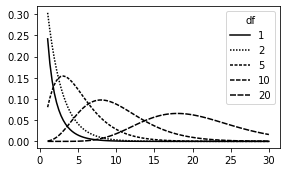

In [31]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

![image info](pics/Chi-Square.png)

### Fisher's Exact Test
Fisher's exact test is a statistical significance test used in the analysis of contingency tables.

Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler. 
```
stats.fisher_exact(clicks)
```

In [32]:
# stats.fisher_exact(clicks.values)

#### Example: Scientific Fraud

An interesting example is provided by the case of Tufts University researcher Thereza
Imanishi-Kari, who was accused in 1991 of fabricating data in her research. Congress‐
man John Dingell became involved, and the case eventually led to the resignation of
her colleague, David Baltimore, from the presidency of Rockefeller University.
One element in the case rested on statistical evidence regarding the expected distribu‐
tion of digits in her laboratory data, where each observation had many digits. Investi‐
gators focused on the interior digits (ignoring the first digit and last digit of a
number), which would be expected to follow a uniform random distribution. That is,
they would occur randomly, with each digit having equal probability of occurring (the
lead digit might be predominantly one value, and the final digits might be affected by
rounding). Table 3-7 lists the frequencies of interior digits from the actual data in the
case.


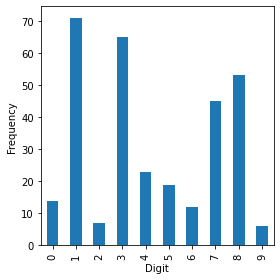

In [33]:
imanishi = pd.read_csv(IMANISHI_CSV)
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x='Digit', y=['Frequency'], legend=False,
                      figsize=(4, 4))
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The distribution of the 315 digits, certainly looks nonrandom.
Investigators calculated the departure from expectation (31.5—that’s how often each
digit would occur in a strictly uniform distribution) and used a chi-square test (a
resampling procedure could equally have been used) to show that the actual distribu‐
tion was well beyond the range of normal chance variation, indicating the data might
have been fabricated. (Note: Imanishi-Kari was ultimately exonerated after a lengthy
proceeding.

## Power and Sample Size

Key Terms for Power and Sample Size
- Effect size:
The minimum size of the effect that you hope to be able to detect in a statistical
test, such as “a 20% improvement in click rates.”
- Power:
The probability of detecting a given effect size with a given sample size.
- Significance level:
The statistical significance level at which the test will be conducted

statsmodels has a number of methods for power calculation

see e.g.: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [61]:
sm.stats.proportion_effectsize?

In [34]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393


In [35]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408


In [64]:
effect_size = sm.stats.proportion_effectsize(0.012, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 140498.254


We see that if we want a power of 80%, we require a sample size of almost 120,000 impressions. If we are seeking a 50% boost
(p1=0.0165), the sample size is reduced to 5,500 impressions.